In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [ ]:
import mplfinance as mpf

def event_K_line(event,n,open_,close,high,low):
    # 输入事件矩阵与天数n
    # T0到Tn-1所有事件的高开低收
    # 返回事件T0到Tn-1的平均高开低收、所有高、开、低、收 
    event_close=pd.DataFrame({'T'+str(i):(event*close.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_open=pd.DataFrame({'T'+str(i):(event*open_.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_high=pd.DataFrame({'T'+str(i):(event*high.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_low=pd.DataFrame({'T'+str(i):(event*low.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    w0=pd.DataFrame({'T'+str(i):event_open.loc[:,'T0'] for i in range(n)})
    mean_event=pd.DataFrame({'open':(event_open/w0).mean(),'close':(event_close/w0).mean(),'high':(event_high/w0).mean(),'low':(event_low/w0).mean()})
    # mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105']) #便于利用mplfinance画图
    return mean_event,event_close,event_open,event_high,event_low

In [423]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/T0open
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/T0open
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    print(data)
    mpf.plot(data,type='candle',style='default')
    return data

#非ST首次涨停(10%)事件的“5日K线图”和“5日分钟累计收益率曲线图”

In [204]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':]).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
# result = result.shift(axis = 1)
result.loc[result.index.str.startswith('300'), :] = np.nan
result.loc[result.index.str.startswith('688'), :] = np.nan
result.loc[result.index.str.endswith('BJ'), :] = np.nan

                open     close       low      high
2020-01-01  1.000000  1.115912  0.991970  1.115912
2020-01-02  1.120199  1.141342  1.079282  1.186450
2020-01-03  1.116589  1.140203  1.082768  1.181345
2020-01-04  1.114327  1.135273  1.082233  1.172652
2020-01-05  1.109897  1.131973  1.078676  1.167167


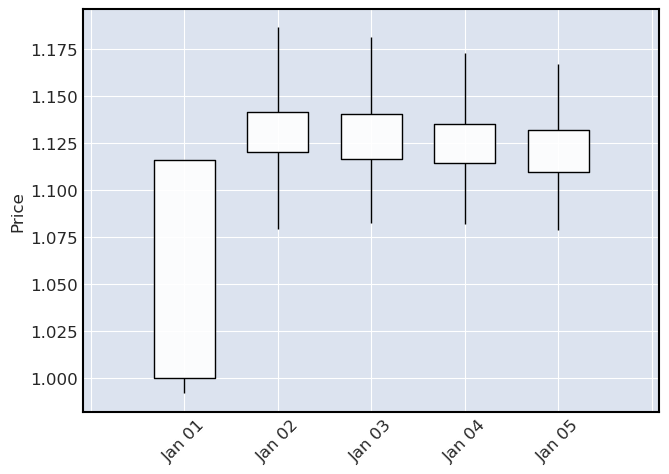

,open,close,low,high
2020-01-01,1.000000,1.115912,0.991970,1.115912
2020-01-02,1.120199,1.141342,1.079282,1.186450
2020-01-03,1.116589,1.140203,1.082768,1.181345
2020-01-04,1.114327,1.135273,1.082233,1.172652
2020-01-05,1.109897,1.131973,1.078676,1.167167


In [212]:
open = ff.read('open')*ff.read('post').loc[:,'20200102':]
close = ff.read('close')*ff.read('post').loc[:,'20200102':]
high = ff.read('high')*ff.read('post').loc[:,'20200102':]
low = ff.read('low')*ff.read('post').loc[:,'20200102':]
daily_K_line(result,5,open,close,high,low)

                open     close       low      high
2020-01-01  1.000000  1.171244  0.990955  1.171244
2020-01-02  1.170442  1.195586  1.111411  1.265401
2020-01-03  1.159969  1.192524  1.111594  1.250833
2020-01-04  1.154174  1.185291  1.111778  1.237738
2020-01-05  1.150706  1.188582  1.113695  1.238385


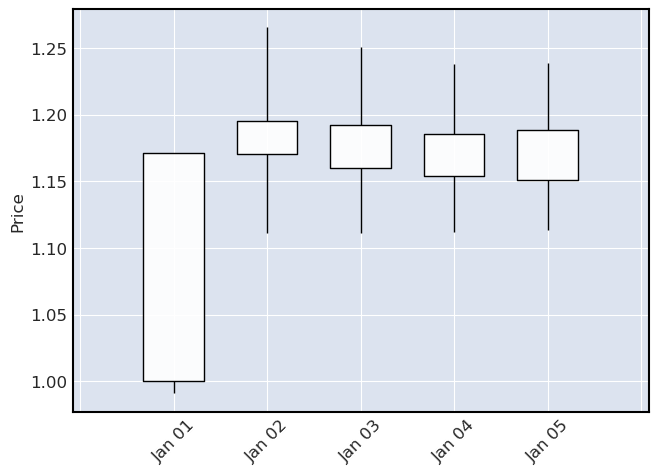

,open,close,low,high
2020-01-01,1.000000,1.171244,0.990955,1.171244
2020-01-02,1.170442,1.195586,1.111411,1.265401
2020-01-03,1.159969,1.192524,1.111594,1.250833
2020-01-04,1.154174,1.185291,1.111778,1.237738
2020-01-05,1.150706,1.188582,1.113695,1.238385


In [213]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':]).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
# result = result.shift(axis = 1)
filtered_index = result.index.str.startswith('300') | result.index.str.startswith('688') | result.index.str.endswith('BJ')
result.loc[~filtered_index,:] = np.nan
open = ff.read('open')*ff.read('post').loc[:,'20200102':]
close = ff.read('close')*ff.read('post').loc[:,'20200102':]
high = ff.read('high')*ff.read('post').loc[:,'20200102':]
low = ff.read('low')*ff.read('post').loc[:,'20200102':]
daily_K_line(result,5,open,close,high,low)

In [100]:
a = ff.read_min('000001.SZ').iloc[:,0:2]

In [57]:
#分钟收益率
a.iloc[:,1]/a.iloc[0,0]

2020-01-02 09:31:00    1.003003
2020-01-02 09:32:00    1.010811
2020-01-02 09:33:00    1.007207
2020-01-02 09:34:00    1.009009
2020-01-02 09:35:00    1.009009
                         ...   
2020-01-02 14:56:00    1.013213
2020-01-02 14:57:00    1.012613
2020-01-02 14:58:00    1.012613
2020-01-02 14:59:00    1.012613
2020-01-02 15:00:00    1.013213
Name: close, Length: 240, dtype: float64

In [2]:
min_list = ff.read('up').loc[:,'20200102':].idxmax(axis = 1).dropna()

In [3]:
def five_day_rets(n):
    min_list = ff.read('up').loc[:,'20200102':'20240306'].idxmax(axis = 1).dropna() 
    stock_list = min_list.index
    date_list = min_list.values
    stock = stock_list[n]
    date = date_list[n]
    ret = ff.read_min(stock).iloc[:,0:2]
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ret.index)]
    ret.insert(0, 'Date', formatted_date_list)
    grouped = ret.groupby(ret['Date'])
    key = [key for key,value in grouped]
    day_list = key[key.index(date):key.index(date)+6]
    fiveday = pd.Series(240)
    # open = grouped.get_group(day_list[0])[:].iloc[0,1]
    for i in range(1,len(day_list)):
        a = grouped.get_group(day_list[i])[:]
        #用所有的价格除以涨停日的收盘价-1，不用cumsum
        close = grouped.get_group(day_list[0])[:].iloc[-1,2]
        a.insert(1,stock,(a.iloc[:,2]/close)-1)
        #每分钟close/上一分钟close=每分钟收益率，第一天除的前一天的收盘价格
        # close = grouped.get_group(day_list[i-1])[:].iloc[-1,2]
        # a.insert(1,stock,(a.iloc[:,2]/a.iloc[:,1]-1))
        # a.iloc[0,1] = a.iloc[0,3]/close - 1
        a.drop(columns=['Date','open','close'], inplace=True)
        a.index = np.arange(240)
        fiveday = pd.concat([fiveday,a],axis = 1)
    fiveday = fiveday.drop(columns=fiveday.columns[0])
    fiveday.columns = [0,1,2,3,4]
    return fiveday

In [4]:
from multiprocessing import Pool
min_list = ff.read('up').loc[:,'20200102':'20240305'].idxmax(axis = 1).dropna()
with Pool(48) as p:
    mean = list(tqdm(p.imap(five_day_rets, range(len(min_list))), total=len(min_list)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 4389/4389 [01:47<00:00, 40.75it/s]


In [5]:
sum_all = pd.DataFrame(0, index=range(240), columns=range(5))
# for i in tqdm(range(len(mean))):
for i in tqdm(range(len(mean))):
    sum_all+=mean[i]
ret_mean = sum_all/len(mean)

100%|███████████████████████████████████████████████████████████████████████████████████████| 4389/4389 [00:01<00:00, 2975.72it/s]


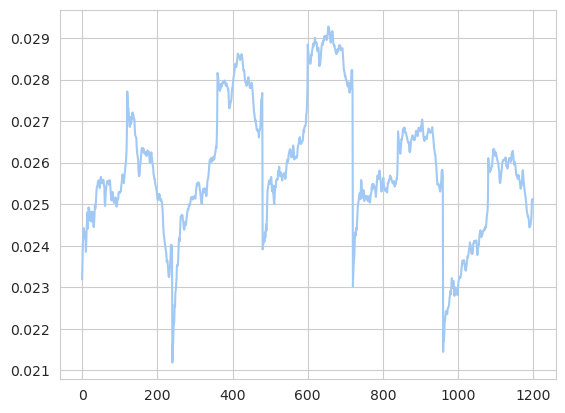

In [6]:
plt.plot(ret_mean.T.values.flatten())

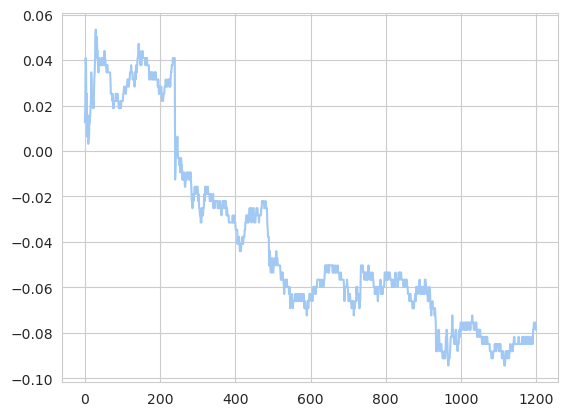

In [7]:
plt.plot(five_day_rets(3).T.values.flatten())

In [501]:
five_day_rets(1)

,0,1,2,3,4
0,-0.014853,0.009700,0.005153,0.007881,0.007275
1,-0.020915,-0.001819,0.006366,0.003637,0.011216
2,-0.010003,-0.006062,0.006366,-0.003941,0.010003
3,-0.011822,-0.006366,0.004547,-0.002728,0.011822
4,-0.010003,-0.002728,0.009094,0.000303,0.012731
...,...,...,...,...,...
235,0.001212,0.008487,0.010003,0.015156,-0.010912
236,0.001212,0.009094,0.008487,0.015459,-0.010003
237,0.001516,0.009397,0.008791,0.015459,-0.010003
238,0.001516,0.009397,0.008791,0.015459,-0.010003


Daily方式（这个方式主要的特点在于对于当日涨停的，会先进行平均，然后再将所有的日期进行平均）

In [366]:
def res_min(i,stock_list,min_list):
    a = (ff.read_min(stock_list[i]).iloc[:,1]/ff.read_min(stock_list[i]).iloc[:,1].shift(1)-1).fillna(0) #计算出每一分钟的收益率
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(a.index)] #生成所有的分钟时间index
    time= min_list[stock_list[i]] #返回每支股票首次涨停的时间
    time_start = formatted_date_list.index(time) 
    return a.iloc[time_start+240:time_start+1440].values #筛选每支股票首次涨停的1200行数据

def daily_ret_min(filter):  #输入需要的event矩阵
    judge = (filter.loc[:,'20200802':'20240305']).cumsum(axis=1)
    result = judge.where(judge.eq(1.0),np.nan)
    min_list = result.loc[:,'20200102':'20240305'].idxmax(axis = 1).dropna()  #每支股票和首次涨停的时间矩阵
    stock_list = min_list.index
    grouped = min_list.groupby(min_list)  #按照日期进行分类，得到每一天有哪些股票涨停
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min('000001.SZ').iloc[:,2].index)]
    temp_list1 = stock_list
    temp_list2 = min_list
    with Pool(48) as p:
        partial_res_min = partial(res_min, stock_list = temp_list1,min_list = temp_list2)
        mean = list(tqdm(p.imap(partial_res_min, range(len(stock_list))), total=len(stock_list)))
    stock_list = (min_list.index).to_list()
    five_day_base = np.zeros(1200)
    for time in list(set(min_list.values)):
        time_stock = list(grouped.get_group(time).index)
        base = np.zeros(1200)
        positions = [stock_list.index(x) if x in stock_list else None for x in time_stock]
        for i in positions:
            base += mean[i]
        five_day_mean = base/len(positions)
        five_day_base+=five_day_mean
    ret_cum = np.array(five_day_base/len(list(set(min_list.values))))
    plt.plot(ret_cum.cumsum())

In [226]:
min_data = ff.read_min('000001.SZ').iloc[:,2]/ff.read_min('000001.SZ').iloc[:,2].shift(1)
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':'20240305']).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
# result = result.shift(axis = 1)
result.loc[result.index.str.startswith('300'), :] = np.nan
result.loc[result.index.str.startswith('688'), :] = np.nan
result.loc[result.index.str.endswith('BJ'), :] = np.nan
filter_ord = result

In [227]:
daily_ret_min(ff.read('up') * filter_ord)

 21%|███████████████████▎                                                                      | 697/3249 [00:19<01:10, 36.18it/s]Process ForkPoolWorker-1738:
Process ForkPoolWorker-1757:
Traceback (most recent call last):
Process ForkPoolWorker-1772:
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-1735:
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.ru

KeyboardInterrupt: 

                open     close       low      high
2020-01-01  1.000000  1.115462  0.991941  1.115462
2020-01-02  1.119590  1.140942  1.078800  1.185812
2020-01-03  1.116307  1.140030  1.082482  1.181207
2020-01-04  1.114122  1.135046  1.082006  1.172484
2020-01-05  1.109787  1.131909  1.078552  1.167110


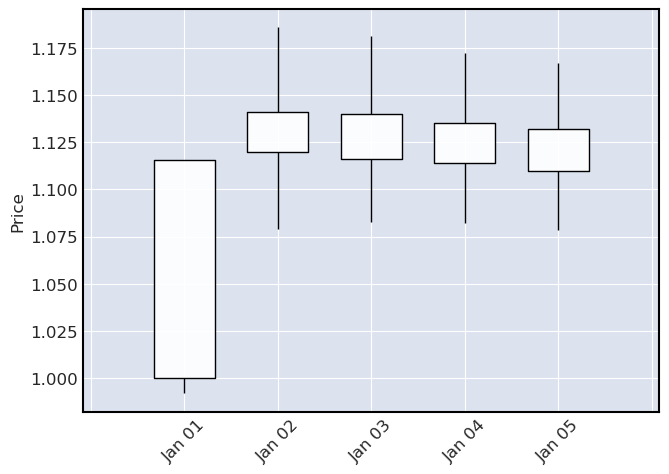

,open,close,low,high
2020-01-01,1.000000,1.115462,0.991941,1.115462
2020-01-02,1.119590,1.140942,1.078800,1.185812
2020-01-03,1.116307,1.140030,1.082482,1.181207
2020-01-04,1.114122,1.135046,1.082006,1.172484
2020-01-05,1.109787,1.131909,1.078552,1.167110


In [215]:
daily_K_line(ff.read('up') * filter_ord,5,open,close,high,low)

一个更快的办法是res_min的时候把时间作为index包含在内，然后concat的时候相同的日期的值会直接合并成一个dataframe之下，然后再对合并大list中的每一项进行平均即可

#### st

In [359]:
filter_st_up = ((ff.read('up_limit')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)<0.055).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st_down = ((ff.read('close')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)>0.049).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st = filter_st_up * filter_st_down
filter_st
judge = ((filter_st).loc[:,'20200102':]).cumsum(axis=1)
filter_st = judge.where(judge.eq(1.0),np.nan)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:10<00:00, 27.29it/s]


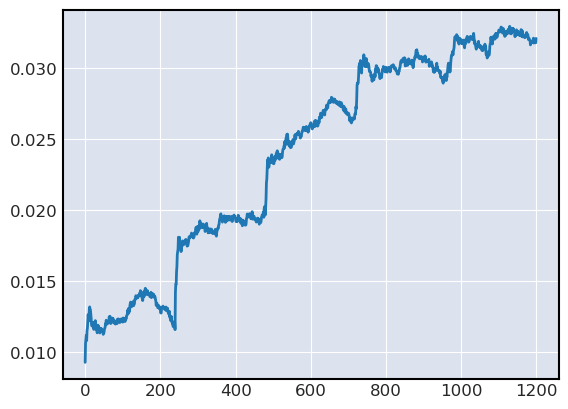

In [360]:
daily_ret_min(filter_st)

                open     close       low      high
2020-01-01  1.000000  1.050413  0.992582  1.050418
2020-01-02  1.054726  1.061780  1.033916  1.083650
2020-01-03  1.059366  1.069915  1.040146  1.090500
2020-01-04  1.064610  1.077091  1.045589  1.097257
2020-01-05  1.071633  1.079974  1.052329  1.102237


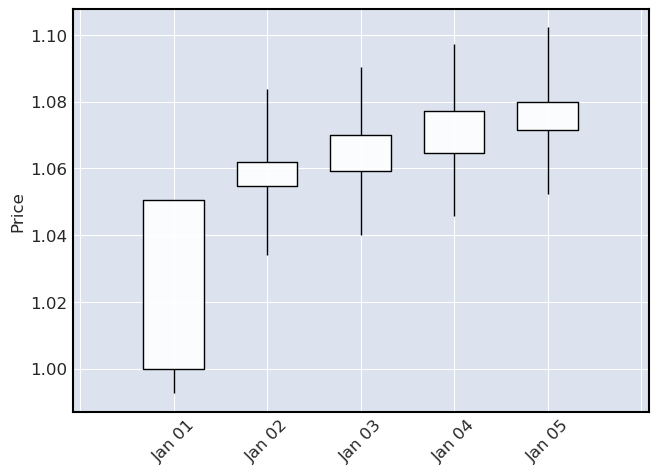

,open,close,low,high
2020-01-01,1.000000,1.050413,0.992582,1.050418
2020-01-02,1.054726,1.061780,1.033916,1.083650
2020-01-03,1.059366,1.069915,1.040146,1.090500
2020-01-04,1.064610,1.077091,1.045589,1.097257
2020-01-05,1.071633,1.079974,1.052329,1.102237


In [361]:
daily_K_line(filter_st,5,open,close,high,low)

#### 创业板

In [367]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200824':]).cumsum(axis=1) #要把daily函数改成0824
result = judge.where(judge.eq(1.0),np.nan)
filtered_index = result.index.str.startswith('300') | result.index.str.startswith('688') | result.index.str.endswith('BJ')
result.loc[~filtered_index,:] = np.nan
ff_300 = result

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:26<00:00, 37.11it/s]


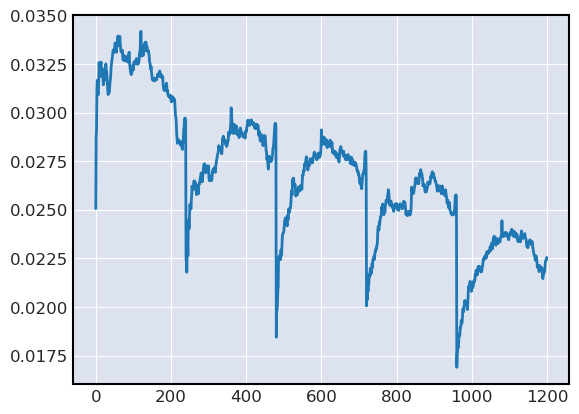

In [364]:
daily_ret_min(ff_300)

                open     close       low      high
2020-01-01  1.000000  1.200026  0.990814  1.200026
2020-01-02  1.196730  1.233420  1.135891  1.310450
2020-01-03  1.189483  1.231761  1.138906  1.296658
2020-01-04  1.185287  1.227642  1.141077  1.287069
2020-01-05  1.182590  1.224943  1.140386  1.280432


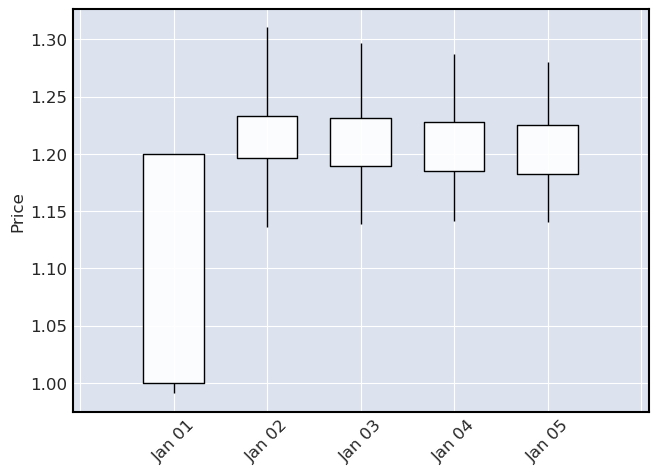

,open,close,low,high
2020-01-01,1.000000,1.200026,0.990814,1.200026
2020-01-02,1.196730,1.233420,1.135891,1.310450
2020-01-03,1.189483,1.231761,1.138906,1.296658
2020-01-04,1.185287,1.227642,1.141077,1.287069
2020-01-05,1.182590,1.224943,1.140386,1.280432


In [365]:
daily_K_line(ff_300,5,open,close,high,low)

#### 首次涨停是指前一天未涨停的情况

In [4]:
filter_first_up = ((ff.read('up').shift(1,axis = 1).replace({1:0,np.nan:1})) * ff.read('up')).replace({0:np.nan})*ff.filter0
filtered_index = filter_first_up.index.str.startswith('300') | filter_first_up.index.str.startswith('688') | filter_first_up.index.str.endswith('BJ')
filter_first_up.loc[filtered_index,:] = np.nan
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']
# daily_K_line(filter_first_up,5,open,close,high,low)

In [15]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+1440,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver

In [16]:
ret_mean = []
with Pool(48) as p:
    ret_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [22:47<00:00,  1.35s/it]


In [21]:
mean = np.mean(ret_mean,axis = 0)

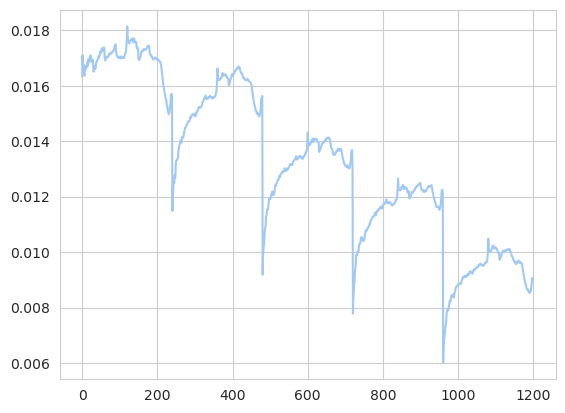

In [23]:
plt.plot(mean-1)

In [ ]:
judge = (filter_st).loc[:,'20200102':].cumsum(axis=1)
result = judge.where(judge.eq(1.0),0)
judge_2 = (filter_st).loc[:,'20200102':] - result
judge_2 = judge_2.shift(-1,axis=1).cumsum(axis = 1)
result_2 = judge_2.where(judge_2.eq(1.0),np.nan)  #第二天依旧涨停的股票
result_2 = result_2.replace({1:0,np.nan:1})
filter_sec = result_2 * result.replace({0:np.nan})